# Top-k upper bounds

## Setup

First up, we need to perform some basic setup tasks. This includes setting up the Jupyter environment, as well as importing important packages and data sets.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import json
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from analysis import selection, workloads
from postgres import explain
from transform import db, mosp, ues

In [3]:
sns.set_theme()
job = workloads.job()


## Analysis of the exhaustive Top-k algorithm

The Top-$k$ workload results are split in several result files, one for each setting of $k$. The results are stored in CSV files that contain information for both the experimental results, as well as for the generated query. Each experiment is repeated a number of times (as indicated by the `run` column). A central task for loading in the data therefore becomes aggregating the results for each $k$ setting, since we do not want to work with each query multiple times.

In [4]:
def read_workload(topk_length: int = np.nan, raw: str = "") -> pd.DataFrame:
    path = f"workloads/topk-setups/job-ues-results-topk-{topk_length}-smart.csv" if not raw else raw
    df = pd.read_csv(path)
    df = selection.best_query_repetition(df, "label", performance_col="query_rt_total")
    df = selection.reorder(df)
    df.set_index("label", inplace=True)
    df["query"] = df["query"].apply(mosp.MospQuery.parse)
    df["ues_bounds"] = df["ues_bounds"].apply(json.loads)
    df["query_result"] = df["query_result"].apply(json.loads)
    df["ues_final_bound"] = df["ues_final_bound"].astype("float")
    
    df.rename(columns={"query_rt_total": "execution_time", "ues_final_bound": "upper_bound"}, inplace=True)
    if not raw:
        df["mode"] = "top-k"
        df["topk_length"] = topk_length
    else:
        df["mode"] = "ues"
        df["topk_length"] = 0
    return df

In [5]:
print("Now reading true query cardinalities")
job_cards = pd.read_csv("workloads/job-results-true-cards.csv", usecols=["label", "query_result"]).rename(columns={"query_result": "true_card"})
print("Now reading UES workload")
all_workloads = [read_workload(raw="workloads/job-ues-results-base-smart.csv")]
for topk_setting in range(1, 6):
    print("Now reading workload for topk =", topk_setting)
    all_workloads.append(read_workload(topk_setting))
results = pd.concat(all_workloads).reset_index().merge(job_cards, on="label")
results["overestimation"] = (results["upper_bound"] + 1) / (results["true_card"] + 1)
results["n_subqueries"] = results["query"].apply(lambda q: len(q.subqueries()))
results["setting"] = np.where(results["mode"] == "ues", "UES", "Top-" + results["topk_length"].astype(str))
settings = pd.Categorical(results["setting"], categories=["UES"] + list(map(lambda k: f"Top-{k}", sorted(filter(lambda k: k > 0, results.topk_length.unique())))), ordered=True)
results["setting"] = settings
results.drop(columns=["optimization_success", "ues_bounds", "query_result", "run"], inplace=True)

Now reading true query cardinalities
Now reading UES workload
Now reading workload for topk = 1
Now reading workload for topk = 2
Now reading workload for topk = 3
Now reading workload for topk = 4
Now reading workload for topk = 5


In [6]:
settings_grp = results.groupby(["mode", "topk_length"])

In [7]:
settings_grp.execution_time.sum()

mode   topk_length
top-k  1              404.438045
       2              404.400480
       3              405.458795
       4              404.149690
       5              403.176833
ues    0              395.697508
Name: execution_time, dtype: float64

In [8]:
settings_grp.upper_bound.describe()

count          mean           std      min          25%  \
mode  topk_length                                                            
top-k 1            113.0  1.030568e+14  5.564665e+14  29997.0  287437560.0   
      2            113.0  9.394045e+13  5.110944e+14  29997.0  245719488.0   
      3            113.0  8.647369e+13  4.689004e+14  29997.0  243820800.0   
      4            113.0  7.149547e+13  3.801703e+14  29997.0  240048240.0   
      5            113.0  6.807758e+13  3.671012e+14  29997.0  221207481.0   
ues   0            113.0  1.030568e+14  5.564665e+14  29997.0  287437560.0   

                            50%           75%           max  
mode  topk_length                                            
top-k 1            8.637352e+09  4.794211e+11  3.446696e+15  
      2            7.809338e+09  4.108778e+11  3.166246e+15  
      3            7.606058e+09  3.544134e+11  2.904369e+15  
      4            7.601100e+09  3.524544e+11  2.353048e+15  
      5            6.442320e+09  3.426590e+11  2.274363e+15  
ues   0            8.637352e+09  4.794211e+11  3.446696e+15

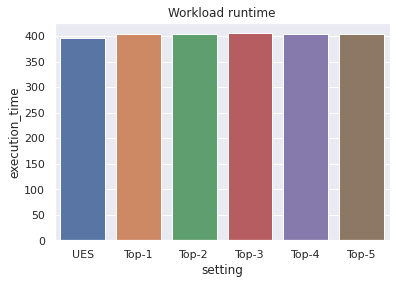

In [9]:
total_topk_runtime = results.groupby(["setting"]).execution_time.sum().to_frame().reset_index()
g = sns.barplot(data=total_topk_runtime, x="setting", y="execution_time")
__ = g.set(title="Workload runtime")

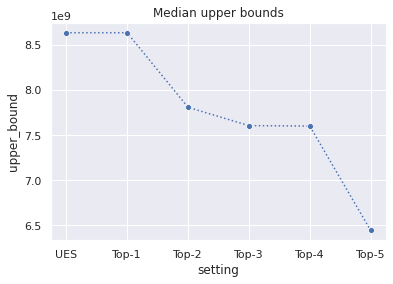

In [10]:
median_topk_bounds = results.groupby("setting").upper_bound.median().to_frame().reset_index()
g = sns.lineplot(data=median_topk_bounds, x="setting", y="upper_bound", linestyle="dotted", marker="o")
__ = g.set(title="Median upper bounds")

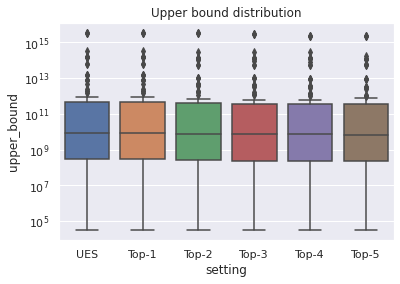

In [11]:
all_topk_bounds = results.copy()
all_topk_bounds.topk_length = all_topk_bounds.topk_length.astype(str)
g = sns.boxplot(data=all_topk_bounds, x="setting", y="upper_bound")
g.set(title="Upper bound distribution")
__ = g.set(yscale="log")

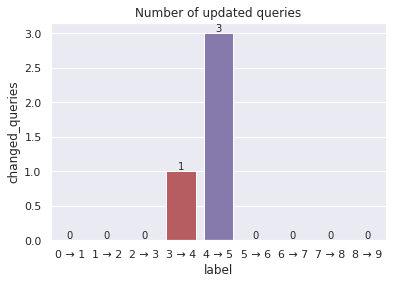

In [12]:
topk_settings = range(9)
topk_setting_successors = range(1, 10)
changed_topk_queries = []
for topk, topk_next in zip(topk_settings, topk_setting_successors):
    topk_results = results[results["topk_length"] == topk].set_index("label")
    topk_next_results = results[results["topk_length"] == topk_next].set_index("label")
    join_path_comparison = pd.merge(topk_results.ues_join_path, topk_next_results.ues_join_path, left_index=True, right_index=True, suffixes=("", "_next"))
    join_path_comparison["stable"] = join_path_comparison.ues_join_path == join_path_comparison.ues_join_path_next
    stable_paths = join_path_comparison.stable.sum()
    changed_paths = len(join_path_comparison) - stable_paths
    label = f"{topk} → {topk_next}"
    changed_topk_queries.append({"topk": topk, "topk_next": topk_next, "changed_queries": changed_paths, "label": label})
changed_topk_queries = pd.DataFrame(changed_topk_queries)
g = sns.barplot(data=changed_topk_queries, x="label", y="changed_queries")
g.set(title="Number of updated queries")
__ = g.bar_label(g.containers[0])

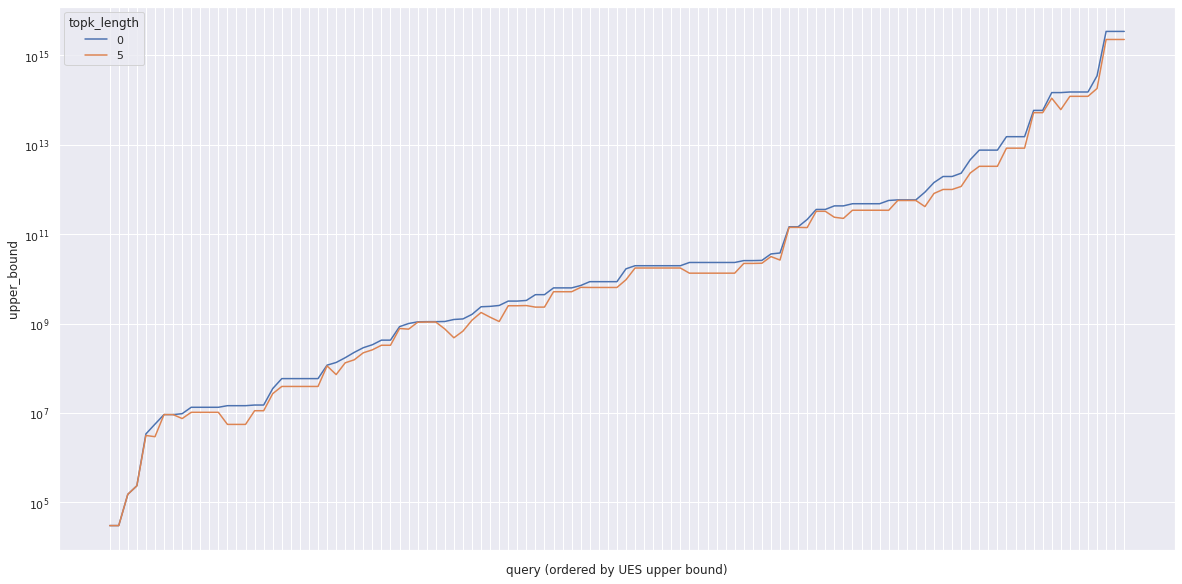

In [13]:
ues_results = results[results["mode"] == "ues"].copy().reset_index()
ues_results.set_index("label", inplace=True)
ues_results.sort_values(by="upper_bound", inplace=True)

plot_df = results[(results["topk_length"] == 0) | (results["topk_length"] == 5)].copy()
label_cats = pd.Categorical(plot_df["label"], categories=ues_results.index, ordered=True)
plot_df["label"] = label_cats
plot_df["topk_length"] = plot_df["topk_length"].astype(str)

fig, ax = plt.subplots(figsize=(20, 10))
g = sns.lineplot(data=plot_df, x="label", y="upper_bound", hue="topk_length", ax=ax)
__ = g.set(yscale="log", xticklabels=[], xlabel="query (ordered by UES upper bound)")

<AxesSubplot:xlabel='setting', ylabel='optimization_time'>

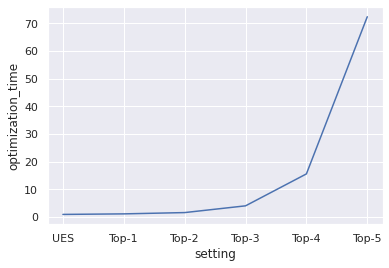

In [14]:
optimization_time = results.groupby("setting").optimization_time.sum().to_frame().reset_index()
sns.lineplot(data=optimization_time, x="setting", y="optimization_time")

## Analysis of the approximate Top-k algorithm

In [15]:
def read_workload_approx(topk_length: int = np.nan, raw: str = "", linear: bool = False) -> pd.DataFrame:
    subquery_suffix = "linear" if linear else "smart"
    path = f"workloads/topk-setups/job-ues-results-topk-{topk_length}-approx-{subquery_suffix}.csv" if not raw else raw
    df = pd.read_csv(path)
    df = selection.best_query_repetition(df, "label", performance_col="query_rt_total")
    df = selection.reorder(df)
    df.set_index("label", inplace=True)
    df["query"] = df["query"].apply(mosp.MospQuery.parse)
    df["ues_bounds"] = df["ues_bounds"].apply(json.loads)
    df["query_result"] = df["query_result"].apply(json.loads)
    df["ues_final_bound"] = df["ues_final_bound"].astype("float")
    
    df.rename(columns={"query_rt_total": "execution_time", "ues_final_bound": "upper_bound"}, inplace=True)
    if not raw:
        df["mode"] = "top-k"
        df["topk_length"] = topk_length
    else:
        df["mode"] = "ues"
        df["topk_length"] = 0
    df["subquery_mode"] = subquery_suffix
    return df

In [16]:
print("Now reading true query cardinalities")
job_cards = pd.read_csv("workloads/job-results-true-cards.csv", usecols=["label", "query_result"]).rename(columns={"query_result": "true_card"})
print("Now reading UES workloads")
all_workloads_approx = [read_workload_approx(raw="workloads/job-ues-results-base-smart.csv"), read_workload_approx(raw="workloads/job-ues-results-base-linear.csv", linear=True)]
for topk_setting in [1, 5, 10, 20, 50, 100, 500]:
    print("Now reading workloads for topk =", topk_setting)
    all_workloads_approx.append(read_workload_approx(topk_setting))
    all_workloads_approx.append(read_workload_approx(topk_setting, linear=True))
results_approx = pd.concat(all_workloads_approx).reset_index().merge(job_cards, on="label")
results_approx["overestimation"] = (results_approx["upper_bound"] + 1) / (results_approx["true_card"] + 1)
results_approx["n_subqueries"] = results_approx["query"].apply(lambda q: len(q.subqueries()))
results_approx["setting"] = np.where(results_approx["mode"] == "ues", "UES", "Top-" + results_approx["topk_length"].astype(str))
settings_approx = pd.Categorical(results_approx["setting"], categories=["UES"] + list(map(lambda k: f"Top-{k}", sorted(filter(lambda k: k > 0, results_approx.topk_length.unique())))), ordered=True)
results_approx["setting"] = settings_approx
results_approx.drop(columns=["optimization_success", "ues_bounds", "query_result", "run"], inplace=True)

Now reading true query cardinalities
Now reading UES workloads
Now reading workloads for topk = 1
Now reading workloads for topk = 5
Now reading workloads for topk = 10
Now reading workloads for topk = 20
Now reading workloads for topk = 50
Now reading workloads for topk = 100
Now reading workloads for topk = 500


In [17]:
approx_settings_grp = results_approx.groupby(["mode", "subquery_mode", "topk_length"])

In [18]:
approx_settings_grp.execution_time.sum()

mode   subquery_mode  topk_length
top-k  linear         1              393.151980
                      5              393.225812
                      10             394.841638
                      20             397.038833
                      50             398.447219
                      100            395.623151
                      500            396.904665
       smart          1              404.168213
                      5              404.213581
                      10             408.743280
                      20             406.914537
                      50             410.514680
                      100            407.449641
                      500            406.041830
ues    linear         0              392.892731
       smart          0              395.697508
Name: execution_time, dtype: float64

In [19]:
approx_settings_grp.upper_bound.describe()

count          mean           std      min  \
mode  subquery_mode topk_length                                               
top-k linear        1            113.0  1.030568e+14  5.564665e+14  29997.0   
                    5            113.0  5.724283e+13  2.904247e+14  29997.0   
                    10           113.0  2.277558e+13  9.518855e+13  29997.0   
                    20           113.0  8.599671e+12  3.043626e+13  29997.0   
                    50           113.0  2.103330e+11  9.711878e+11  29997.0   
                    100          113.0  5.912595e+11  3.997912e+12  29997.0   
                    500          113.0  4.315926e+12  3.289810e+13  29997.0   
      smart         1            113.0  1.030568e+14  5.564665e+14  29997.0   
                    5            113.0  5.724283e+13  2.904247e+14  29997.0   
                    10           113.0  2.277558e+13  9.518855e+13  29997.0   
                    20           113.0  8.599671e+12  3.043626e+13  29997.0   
                    50           113.0  2.103330e+11  9.711878e+11  29997.0   
                    100          113.0  5.912595e+11  3.997912e+12  29997.0   
                    500          113.0  4.315926e+12  3.289810e+13  29997.0   
ues   linear        0            113.0  1.030568e+14  5.564665e+14  29997.0   
      smart         0            113.0  1.030568e+14  5.564665e+14  29997.0   

                                         25%           50%           75%  \
mode  subquery_mode topk_length                                            
top-k linear        1            287437560.0  8.637352e+09  4.794211e+11   
                    5            227350720.0  6.663612e+09  4.404520e+11   
                    10           146472332.0  6.218292e+09  2.721715e+11   
                    20            93218066.0  4.658380e+09  1.443800e+11   
                    50            50717370.0  2.771403e+09  1.444402e+10   
                    100           17455392.0  8.962438e+08  5.899555e+09   
                    500            8740118.0  1.572989e+08  2.129704e+09   
      smart         1            287437560.0  8.637352e+09  4.794211e+11   
                    5            227350720.0  6.663612e+09  4.404520e+11   
                    10           146472332.0  6.218292e+09  2.721715e+11   
                    20            93218066.0  4.658380e+09  1.443800e+11   
                    50            50717370.0  2.771403e+09  1.444402e+10   
                    100           17455392.0  8.962438e+08  5.899555e+09   
                    500            8740118.0  1.572989e+08  2.129704e+09   
ues   linear        0            287437560.0  8.637352e+09  4.794211e+11   
      smart         0            287437560.0  8.637352e+09  4.794211e+11   

                                          max  
mode  subquery_mode topk_length                
top-k linear        1            3.446696e+15  
                    5            1.793214e+15  
                    10           5.652241e+14  
                    20           1.558602e+14  
                    50           7.270661e+12  
                    100          3.030897e+13  
                    500          2.924113e+14  
      smart         1            3.446696e+15  
                    5            1.793214e+15  
                    10           5.652241e+14  
                    20           1.558602e+14  
                    50           7.270661e+12  
                    100          3.030897e+13  
                    500          2.924113e+14  
ues   linear        0            3.446696e+15  
      smart         0            3.446696e+15

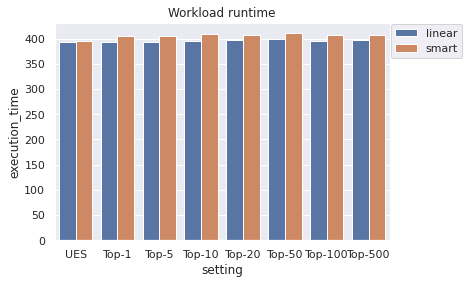

In [20]:
total_topk_runtime = results_approx.groupby(["setting", "subquery_mode"]).execution_time.sum().to_frame().reset_index()
g = sns.barplot(data=total_topk_runtime, x="setting", y="execution_time", hue="subquery_mode")
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)
__ = g.set(title="Workload runtime")

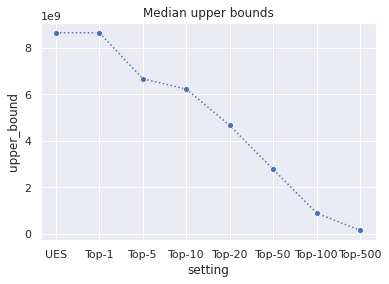

In [21]:
median_topk_bounds = results_approx[results_approx["subquery_mode"] == "linear"].groupby("setting").upper_bound.median().to_frame().reset_index()
g = sns.lineplot(data=median_topk_bounds, x="setting", y="upper_bound", linestyle="dotted", marker="o")
__ = g.set(title="Median upper bounds")

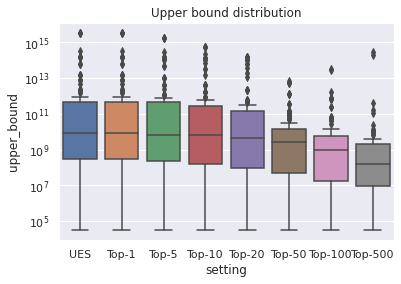

In [22]:
all_topk_bounds = results_approx[results_approx["subquery_mode"] == "linear"].copy()
all_topk_bounds.topk_length = all_topk_bounds.topk_length.astype(str)
g = sns.boxplot(data=all_topk_bounds, x="setting", y="upper_bound")
g.set(title="Upper bound distribution")
__ = g.set(yscale="log")

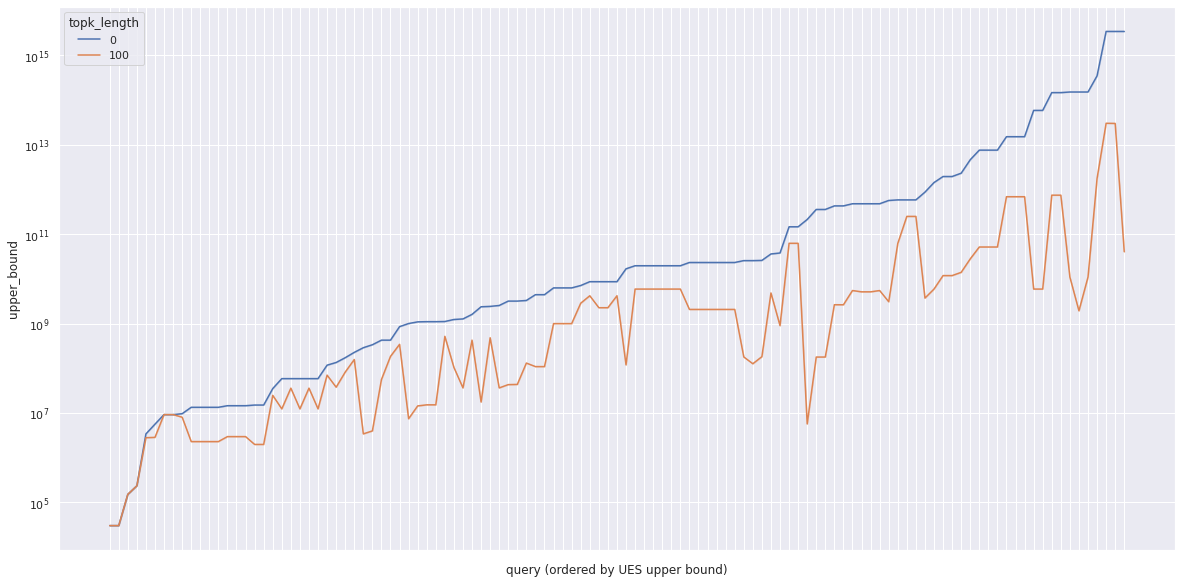

In [23]:
ues_results = results_approx[(results_approx["mode"] == "ues") & (results_approx["subquery_mode"] == "linear")].copy().reset_index()
ues_results.set_index("label", inplace=True)
ues_results.sort_values(by="upper_bound", inplace=True)

plot_df = results_approx[(results_approx["topk_length"] == 0) | (results_approx["topk_length"] == 100)].copy()
label_cats = pd.Categorical(plot_df["label"], categories=ues_results.index, ordered=True)
plot_df["label"] = label_cats
plot_df["topk_length"] = plot_df["topk_length"].astype(str)

fig, ax = plt.subplots(figsize=(20, 10))
g = sns.lineplot(data=plot_df, x="label", y="upper_bound", hue="topk_length", ax=ax)
__ = g.set(yscale="log", xticklabels=[], xlabel="query (ordered by UES upper bound)")

# + real cardinality

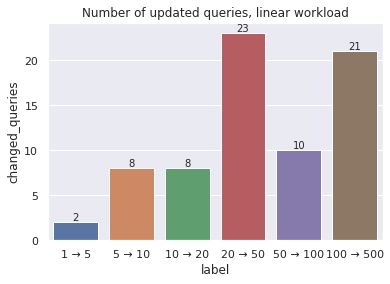

In [24]:
topk_settings = [1, 5, 10, 20, 50, 100]
topk_setting_successors = [5, 10, 20, 50, 100, 500]
changed_topk_queries = []
for topk, topk_next in zip(topk_settings, topk_setting_successors):
    topk_results = results_approx[(results_approx["topk_length"] == topk) & (results_approx["subquery_mode"] == "linear")].set_index("label")
    topk_next_results = results_approx[(results_approx["topk_length"] == topk_next) & (results_approx["subquery_mode"] == "linear")].set_index("label")
    join_path_comparison = pd.merge(topk_results.ues_join_path, topk_next_results.ues_join_path, left_index=True, right_index=True, suffixes=("", "_next"))
    join_path_comparison["stable"] = join_path_comparison.ues_join_path == join_path_comparison.ues_join_path_next
    stable_paths = join_path_comparison.stable.sum()
    changed_paths = len(join_path_comparison) - stable_paths
    label = f"{topk} → {topk_next}"
    changed_topk_queries.append({"topk": topk, "topk_next": topk_next, "changed_queries": changed_paths, "label": label})
changed_topk_queries = pd.DataFrame(changed_topk_queries)
g = sns.barplot(data=changed_topk_queries, x="label", y="changed_queries")
g.set(title="Number of updated queries, linear workload")
__ = g.bar_label(g.containers[0])

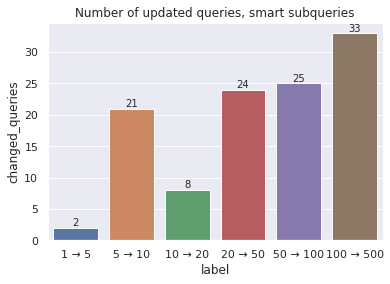

In [25]:
topk_settings = [1, 5, 10, 20, 50, 100]
topk_setting_successors = [5, 10, 20, 50, 100, 500]
changed_topk_queries = []
for topk, topk_next in zip(topk_settings, topk_setting_successors):
    topk_results = results_approx[(results_approx["topk_length"] == topk) & (results_approx["subquery_mode"] == "smart")].set_index("label")
    topk_next_results = results_approx[(results_approx["topk_length"] == topk_next) & (results_approx["subquery_mode"] == "smart")].set_index("label")
    join_path_comparison = pd.merge(topk_results.ues_join_path, topk_next_results.ues_join_path, left_index=True, right_index=True, suffixes=("", "_next"))
    join_path_comparison["stable"] = join_path_comparison.ues_join_path == join_path_comparison.ues_join_path_next
    stable_paths = join_path_comparison.stable.sum()
    changed_paths = len(join_path_comparison) - stable_paths
    label = f"{topk} → {topk_next}"
    changed_topk_queries.append({"topk": topk, "topk_next": topk_next, "changed_queries": changed_paths, "label": label})
changed_topk_queries = pd.DataFrame(changed_topk_queries)
g = sns.barplot(data=changed_topk_queries, x="label", y="changed_queries")
g.set(title="Number of updated queries, smart subqueries")
__ = g.bar_label(g.containers[0])

<AxesSubplot:xlabel='setting', ylabel='optimization_time'>

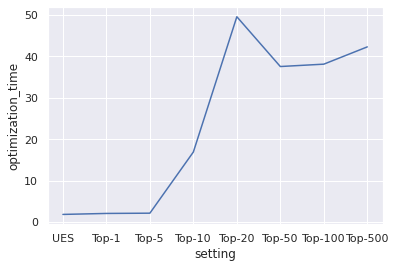

In [26]:
optimization_time = results_approx.groupby("setting").optimization_time.sum().to_frame().reset_index()
sns.lineplot(data=optimization_time, x="setting", y="optimization_time")